In [1]:
!cp "/content/drive/MyDrive/xray.zip" "/";

In [2]:
!unzip -q "/xray.zip" -d "/";

In [3]:
from tensorflow.keras import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

# Part 1 : Reading Data

In [4]:
dataGenerator_normal = preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
dataGenerator = preprocessing.image.ImageDataGenerator()

def get_data(path, normalize, shuff):
  if normalize:
    return dataGenerator_normal.flow_from_directory(
        path, target_size=(80,80), color_mode="grayscale", batch_size=32, shuffle=shuff)
  else:
    return dataGenerator.flow_from_directory(
        path, target_size=(80,80), color_mode="grayscale", batch_size=32, shuffle=shuff)
    
print('not normalized, not shuffled:')
dataTrain_noshuf, dataTest_noshuf = get_data("/Data/train", False, False), get_data("/Data/test", False, False)

print('normalized, not shuffled:')
dataTrain_noshuf_normal, dataTest_noshuf_normal = get_data("/Data/train", True, False), get_data("/Data/test", True, False)

print('not normalized, shuffled:')
dataTrain, dataTest = get_data("/Data/train", False, True), get_data("/Data/test", False, True)

print('normalized, shuffled:')
dataTrain_normal, dataTest_normal = get_data("/Data/train", True, True), get_data("/Data/test", True, True)

not normalized, not shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
normalized, not shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
not normalized, shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
normalized, shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# Part Two: Visualization

Found 5144 images belonging to 3 classes.


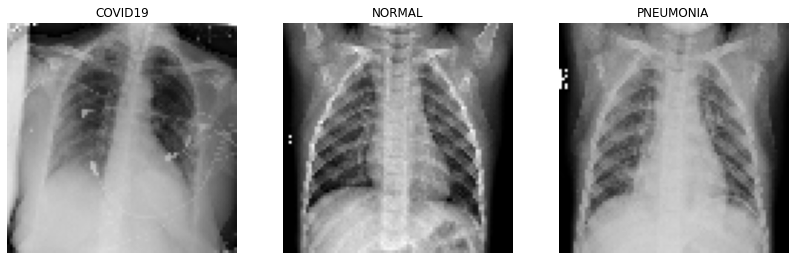

In [5]:
current_class = 0
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
dataPlot = dataGenerator.flow_from_directory("/Data/train", target_size=(80,80), color_mode="grayscale", batch_size=1, shuffle=False)

fig, ax = plt.subplots(1, 3, figsize=(14,5))

for i in range(len(dataPlot.classes)):
  if dataPlot.classes[i] == current_class:
    img = dataPlot[i+5][0][0]
    ax[current_class].imshow(img[:,:,0], cmap=plt.get_cmap('gray'))
    ax[current_class].set_axis_off()
    ax[current_class].set_title(class_names[current_class])
    current_class += 1

Text(0, 0.5, 'count')

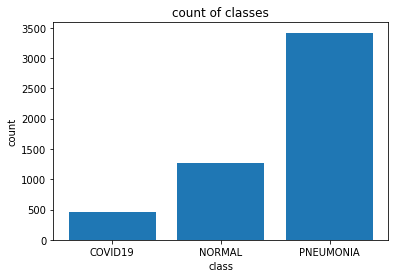

In [6]:
counts = np.unique(dataPlot.classes, return_counts=True)
plt.bar(counts[0], counts[1], tick_label=class_names);
plt.title('count of classes')
plt.xlabel('class')
plt.ylabel('count')

# Part 3: Creating Model

In [12]:
class Root:

  def __init__(self, d_train, d_test, d_train_noshuf, d_test_noshuf):
    self.model = None
    self.d_train = d_train
    self.d_test = d_test
    self.d_train_noshuf = d_train_noshuf
    self.d_test_noshuf = d_test_noshuf

  def create_model(self, act_func):
    input_layer = layers.Input(shape=(80, 80, 1))
    out = layers.Flatten()(input_layer)
    out = layers.Dense(2048, activation= act_func)(out)
    out = layers.Dense(4096, activation= act_func)(out)
    out = layers.Dense(4096, activation= act_func)(out)
    out = layers.Dense(1024, activation= act_func)(out)
    out = layers.Dense(4096, activation= act_func)(out)
    out = layers.Dense(3, activation= activations.softmax)(out)
    model = models.Model(inputs= input_layer, outputs= out)
    self.model = model
    return model

  def get_model(self):
    return self.model

  def compile(self):
    self.model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01), loss=losses.categorical_crossentropy, metrics=["accuracy"]
    )
  
  def print_summary(self):
    self.model.summary()

  def plot_epochs(self, history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    train_accs = history['accuracy']
    train_loss = history['loss']
    test_accs = history['val_accuracy']
    test_loss = history['val_loss']
    epoches = np.arange(len(train_accs))
    ax[0].plot(epoches, train_accs, test_accs)
    ax[1].plot(epoches, train_loss, test_loss)

  def fit(self, epochs):
    history = self.model.fit(self.d_train, validation_data= self.d_test, epochs=epochs)
    return history.history

  def __get_preds(self, y):
    y_pred_raw = self.model.predict(y)
    y_pred = np.rint(y_pred_raw).argmax(axis=1)
    return y_pred

  def print_reports(self):
    y_train_preds, y_test_preds = self.__get_preds(d_train_noshuf), self.__get_preds(d_test_noshuf)
    print('Classification Report For Train Data:')
    print('#'*60)
    print(classification_report(dataTrain.classes, y_train_preds))
    print('\nClassification Report For Test Data:')
    print('#'*60)
    print(classification_report(dataTest.classes, y_test_preds))

  def run(self, act_func, epochs):
    start_time = time.time()
    print('creating  model...', )
    self.create_model(act_func)
    print('compiling model...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.compile()
    print('training  model...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    history = self.fit(epochs)
    print('plotting epochs...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.plot_epochs(history)
    print('printing reports...','elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.print_reports()
    print('elapsed time = {} mins {} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))

In [10]:
d_train, d_test = dataTrain, dataTest
d_train_noshuf, d_test_noshuf = dataTrain_noshuf, dataTest_noshuf

root_relu = Root(d_train, d_test, d_train_noshuf, d_test_noshuf)
root_relu.create_model(activations.relu)
root_relu.print_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              13109248  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              419840

# Part 4: Training Model

In [ ]:
root_relu = Root(d_train, d_test, d_train_noshuf, d_test_noshuf)
root_relu.run(activations.relu, epochs=2)

creating  model...
compiling model... elapsed time = 0.0 mins 0.04 secs
training  model... elapsed time = 0.0 mins 0.05 secs
Epoch 1/2
161/161 [==============================] - 142s 884ms/step - loss: 1.3944 - accuracy: 0.5951 - val_loss: 0.8197 - val_accuracy: 0.6638
Epoch 2/2
161/161 [==============================] - 141s 876ms/step - loss: 0.8512 - accuracy: 0.6528 - val_loss: 0.8412 - val_accuracy: 0.6638
plotting epochs... elapsed time = 4.0 mins 44.12 secs
printing reports... elapsed time = 4.0 mins 44.15 secs


NameError: ignored

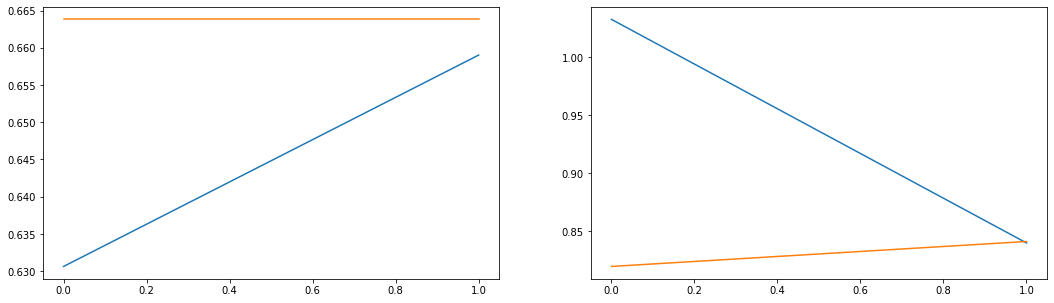

In [13]:
root_tanh = Root(d_train, d_test, d_train_noshuf, d_test_noshuf)
root_tanh.run(activations.tanh, epochs=2)

In [83]:
m = root_relu.get_model()

In [87]:
m.history.history['accuracy']

KeyError: ignored

# New Section